Report
0. Most time unfortunately spent fixing a broken Anaconda installation from years ago...
1. Failed to install various version of MuJoCo on Windows.
2. Installed MuJoCo on colab, minus the viewer.
3. Found a broken ready-made PPO implementation (99 % of code). Modified it.
4. Wrote a reward function and light hyperparameter tuning. The reward idea is a product of upright angle and a Gaussian weighting the distance to the target point.
5. The code is admittedly resarch code, slow and visualization is broken, but reward seems high enough that I guess it kind of works. I deserve minus points in code quality, though.
What would speed up training:
A) Hyperparameter tuning
B) Use differentiable sim/surrogate if allowed
C) Use bootstrapping for critic rather than MC
D) Reimplement compiled training loop
E) Use deterministic policy gradients
F) Code optimizations such as minimizing allocations, use eligibility traces etc
G) Generative world model
H) A few secret tricks up my sleeve
6. Rewriting the entire training loop in Julia for testing some new algorithm, but this needs a day or two and has to wait for the holiday.The new solver packages from JuliaSim/MIT with surrogate modeling support could accelerate training and that the upcoming Julia AoT compiler developments could also greatly facilitate deployment directly to various controllers. Could be fun to investigate in any case.
7. Will modify code of the MuJoCo model to make it POMDP.

################################################################################
> # **Install Dependencies**
################################################################################

In [4]:


############ install compatible version of OpenAI roboschool and gym ###########

!pip install swig
#!pip install mujoco
#Did not work

!pip install gymnasium



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 9.9 MB/s eta 0:00:00


################################################################################
> # **Introduction**
> The notebook is divided into 5 major parts :

*   **Part I** : define actor-critic network and PPO algorithm
*   **Part II** : train PPO algorithm and save network weights and log files
*   **Part III** : load (preTrained) network weights and test PPO algorithm
*   **Part IV** : load log files and plot graphs
*   **Part V** : install xvbf, load (preTrained) network weights and save images for gif and then generate gif

################################################################################

################################################################################
> # **Part - I**

*   define actor critic networks
*   define PPO algorithm

################################################################################

In [5]:


############################### Import libraries ###############################

import os
#Mujoco that works in colab
if not os.path.exists('.mujoco_setup_complete'):
  # Get the prereqs
  !apt-get -qq update
  !apt-get -qq install -y libosmesa6-dev libgl1-mesa-glx libglfw3 libgl1-mesa-dev libglew-dev patchelf
  # Get Mujoco
  !mkdir ~/.mujoco
  !wget -q https://mujoco.org/download/mujoco210-linux-x86_64.tar.gz -O mujoco.tar.gz
  !tar -zxf mujoco.tar.gz -C "$HOME/.mujoco"
  !rm mujoco.tar.gz
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  !echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$HOME/.mujoco/mujoco210/bin' >> ~/.bashrc
  !echo 'export LD_PRELOAD=$LD_PRELOAD:/usr/lib/x86_64-linux-gnu/libGLEW.so' >> ~/.bashrc
  # THE ANNOYING ONE, FORCE IT INTO LDCONFIG SO WE ACTUALLY GET ACCESS TO IT THIS SESSION
  !echo "/root/.mujoco/mujoco210/bin" > /etc/ld.so.conf.d/mujoco_ld_lib_path.conf
  !ldconfig
  # Install Mujoco-py
  !pip3 install -U 'mujoco'
  # run once
  !touch .mujoco_setup_complete

try:
  if _mujoco_run_once:
    pass
except NameError:
  _mujoco_run_once = False
if not _mujoco_run_once:
  # Add it to the actively loaded path and the bashrc path (these only do so much)
  try:
    os.environ['LD_LIBRARY_PATH']=os.environ['LD_LIBRARY_PATH'] + ':/root/.mujoco/mujoco210/bin'
  except KeyError:
    os.environ['LD_LIBRARY_PATH']='/root/.mujoco/mujoco210/bin'
  try:
    os.environ['LD_PRELOAD']=os.environ['LD_PRELOAD'] + ':/usr/lib/x86_64-linux-gnu/libGLEW.so'
  except KeyError:
    os.environ['LD_PRELOAD']='/usr/lib/x86_64-linux-gnu/libGLEW.so'
  # presetup so we don't see output on first env initialization
  import mujoco
  import mujoco.viewer
  _mujoco_run_once = True
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gymnasium as gym
import gymnasium.spaces as spaces
import math

import time




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libglx-dev:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../00-libglx-dev_1.4.0-1_amd64.deb ...
Unpacking libglx-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libgl-dev:amd64.
Preparing to unpack .../01-libgl-dev_1.4.0-1_amd64.deb ...
Unpacking libgl-dev:amd64 (1.4.0-1) ...
Selecting previously unselected package libegl-dev:amd64.
Preparing to unpack .../02-libegl-dev_1.4.0-1_amd64.deb ...
Unpacking libegl-dev:amd64 (1.4.0-1) ...
Preparing to unpack .../03-libegl-mesa0_23.2.1-1ubuntu3.1~22.04.3_amd64.deb ...
Unpacking libegl-mesa0:amd64 (23.2.1-1ubuntu3.1~22.04.3) over (23.2.1-1ubuntu3.1~22.04.2) ...
Preparing to unpack .../04-libgbm1_23.2.1-1ubuntu3.1~22.04.3_amd64.deb ...
Unpacking libgb

In [6]:
class InvertedPendulumEnv:
    xml_env = """
    <mujoco model="inverted pendulum">
            <visual>
            <headlight diffuse="0.6 0.6 0.6" ambient="0.3 0.3 0.3" specular="0 0 0"/>
            <rgba haze="0.15 0.25 0.35 1"/>
            <global azimuth="160" elevation="-20"/>
        </visual>

        <asset>
            <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
        </asset>
        <compiler inertiafromgeom="true"/>
        <default>
            <joint armature="0" damping="1" limited="true"/>
            <geom contype="0" friction="1 0.1 0.1" rgba="0.0 0.7 0 1"/>
            <tendon/>
            <motor ctrlrange="-3 3"/>
        </default>
        <option gravity="0 0 -9.81" integrator="RK4" timestep="0.02"/>
        <size nstack="3000"/>
        <worldbody>
            <light pos="0 0 3.5" dir="0 0 -1" directional="true"/>
            <!--geom name="ground" type="plane" pos="0 0 0" /-->
            <geom name="rail" pos="0 0 0" quat="0.707 0 0.707 0" rgba="0.3 0.3 0.7 1" size="0.02 1" type="capsule" group="3"/>
            <body name="cart" pos="0 0 0">
                <joint axis="1 0 0" limited="true" name="slider" pos="0 0 0" range="-1 1" type="slide"/>
                <geom name="cart" pos="0 0 0" quat="0.707 0 0.707 0" size="0.1 0.1" type="capsule"/>
                <body name="pole" pos="0 0 0">
                    <joint axis="0 1 0" name="hinge" pos="0 0 0" range="-100000 100000" type="hinge"/>
                    <geom fromto="0 0 0 0.001 0 0.6" name="cpole" rgba="0 0.7 0.7 1" size="0.049 0.3" type="capsule"/>
                </body>
            </body>
        </worldbody>
        <actuator>
            <motor ctrllimited="true" ctrlrange="-3 3" gear="100" joint="slider" name="slide"/>
        </actuator>
    </mujoco>
    """

    def __init__(
        self,
    ):
        self.init_qpos = np.zeros(2)
        self.init_qvel = np.zeros(2)
        self.model = mujoco.MjModel.from_xml_string(InvertedPendulumEnv.xml_env)
        self.data = mujoco.MjData(self.model)
        #self.viewer = mujoco.viewer.launch_passive(self.model, self.data) #Headless mode required in colab
        self.reset_model()
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float64)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float64)

    def step(self, a):
        self.data.ctrl = a
        mujoco.mj_step(self.model, self.data)
        #self.viewer.sync() #Headless mode required in colab
        reward = 0.0025*math.cos(self.data.qpos[1]) * math.exp(-((self.data.qpos[0] - 0.2)/6)**2)
        ob = self.obs()
        terminated = bool(not np.isfinite(ob).all())
        return ob, reward, terminated

    def obs(self):
        return np.concatenate([self.data.qpos, self.data.qvel]).ravel()

    def reset_model(self):
        self.data.qpos = self.init_qpos
        self.data.qvel = self.init_qvel
        self.data.qpos[1] = 3.14  # Set the pole to be facing down
        return self.obs()

    def set_dt(self, new_dt):
        """Sets simulations step"""
        self.model.opt.timestep = new_dt

    def draw_ball(self, position, color=[1, 0, 0, 1], radius=0.01):
        mujoco.mjv_initGeom(
            #self.viewer.user_scn.geoms[0], #Headless mode required in colab
            type=mujoco.mjtGeom.mjGEOM_SPHERE,
            size=[radius, 0, 0],
            pos=np.array(position),
            mat=np.eye(3).flatten(),
            rgba=np.array(color),
        )
        #self.viewer.user_scn.ngeom = 1 #Headless mode required in colab

    def reset(self):
      return self.reset_model()

    @property
    def current_time(self):
        return self.data.time




env = InvertedPendulumEnv()

In [7]:


################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")

print("============================================================================================")




Device set to : cpu


In [8]:


################################## PPO Policy ##################################


class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []


    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]



In [9]:

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Mish(),
                            nn.Linear(64, 64),
                            nn.Mish(),
                            nn.Linear(64, action_dim)
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )


        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Mish(),
                        nn.Linear(64, 64),
                        nn.Mish(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError


    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


In [10]:


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)

        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                #state = torch.FloatTensor(state).to(device) #L Changed for below:
                state = torch.tensor(state,dtype=torch.float32).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                #state = torch.FloatTensor(state).to(device) #L Changed for below:
                state = torch.tensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()


        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards)# - 0.01 * dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()


    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)


    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))






In [11]:



################################# End of Part I ################################




################################################################################
> # **Part - II**

*   train PPO algorithm on environments
*   save preTrained networks weights and log files

################################################################################

In [12]:

print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "Inverted Pendulum in MuJoCo"
env = InvertedPendulumEnv()
has_continuous_action_space = True
action_std = 1.9
action_std_decay_rate = 0.02
min_action_std = 0.05
action_std_decay_freq = 10000

max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(20e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)



#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.98                # discount factor

lr_actor = 0.0001       # learning rate for actor network
lr_critic = 0.0003       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

#env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps")
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:

    state = env.reset()
    #state = state[0] #
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):

        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)

        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0

        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
#env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







training environment name : Inverted Pendulum in MuJoCo
current logging run number for Inverted Pendulum in MuJoCo :  0
logging at : PPO_logs/Inverted Pendulum in MuJoCo//PPO_Inverted Pendulum in MuJoCo_log_0.csv
save checkpoint path : PPO_preTrained/Inverted Pendulum in MuJoCo/PPO_Inverted Pendulum in MuJoCo_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  2000000
max timesteps per episode :  400
model saving frequency : 20000 timesteps
log frequency : 800 timesteps
printing average reward over episodes in last : 1600 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  4
action space dimension :  1
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
startin

################################################################################
> # **Part - IV**

*   load log files using pandas
*   plot graph using matplotlib

################################################################################

loading data from : PPO_logs/Inverted Pendulum in MuJoCo//PPO_Inverted Pendulum in MuJoCo_log_0.csv
data shape :  (2500, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/Inverted Pendulum in MuJoCo//PPO_Inverted Pendulum in MuJoCo_fig_0.png


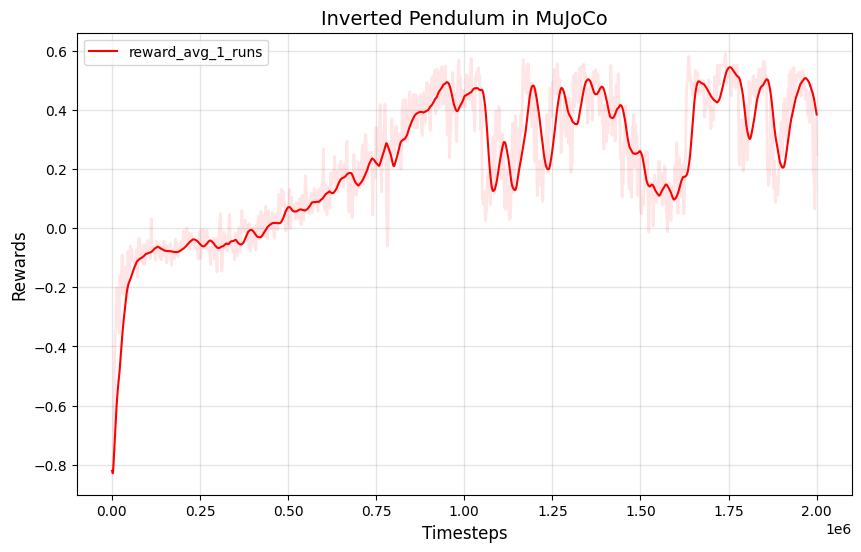

In [13]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")



fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)

    print("data shape : ", data.shape)

    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()


